# Classification of architecture
-----
Задача: сделать систему классификации зданий по архитектурному стилю

План работы над задачей:
- Какие есть методы классификации изображений? (изучение теории)
- Предварительная работа над задачей
    - Сбор данных
    - Подготовка данных для моделей
    - Построение пайплайнов
    - Выбор итоговой модели для улучшения
- Создание пайплайна для готовой модели
- Подведение итогов 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from PIL import Image
import os
import sys
import shutil


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, AdaBoostClassifier, GradientBoostingClassifier

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision

### Загрузка данных
Для задачи был взят готовый набор данных с Kaggle\
https://www.kaggle.com/datasets/gustavoachavez/architectural-styles-periods-dataset


In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d gustavoachavez/architectural-styles-periods-dataset
!ls -l
import zipfile
with zipfile.ZipFile('architectural-styles-periods-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

Saving kaggle.json to kaggle.json
100% 1.98G/1.98G [01:06<00:00, 25.3MB/s]
100% 1.98G/1.98G [01:06<00:00, 32.0MB/s]
total 2080212
-rw-r--r-- 1 root root 2130121868 Nov 30 14:44 architectural-styles-periods-dataset.zip
-rw-r--r-- 1 root root         67 Nov 30 14:42 kaggle.json
drwxr-xr-x 1 root root       4096 Nov 22 00:14 sample_data


## Постановка задачи
Сделать модель, метрика точности accuracy будет больше 0.8

Для начала, хотелось бы убедиться, что стандартные алгоритмы машинного обучения не так эффективны для работы с изображениями, чем нейросети

Рассмотрим следующие алгоритмы:
- Knn – метод ближайших соседей
- Random forest – случайный лес
- SVM – метод опорных векторов
- Ансамбли
- Neural networks 
  - FNN
  - CNN
  - Готовые архитектуры

## Base


### Подготовка данных

None
(256, 256)
L
(256, 256)


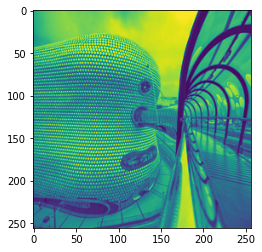

In [ ]:
# просмотр изображений и конвертация в монохром
path = '/content/Capstone_Architectural_Styles_dataset/21st_Century/Blobitecture/000.jpg'
im = Image.open(path).resize((256, 256)).convert('L')
print(im.format)
print(im.size)
print(im.mode)
n = np.array(im)
print(n.shape)
plt.imshow(n)
plt.show()

In [ ]:
# сделаем класс для сбора датасета в numpy 
class Collector:
  def __init__(self, size_image):
    self.fill = False
    self.con_data=None
    self.con_target=None
    self.size_image = size_image

  def collect_image(self, path, target_num, sample_count=None, convert='L'):
    size = self.size_image
    listdir = os.listdir(path)
    
    if sample_count:
      if convert == 'RGB':
        data = np.zeros((sample_count, 3, size, size), dtype=int)
      else:
        data = np.zeros((sample_count, size, size), dtype=int)
      target = np.full(shape=sample_count, fill_value=target_num, dtype=int)
      for i in range(sample_count):
        im = Image.open(path+listdir[i]).resize((size, size)).convert(convert)
        data[i] = np.array(im).T
    else:
      if convert == 'RGB':
        data = np.zeros((len(listdir), 3, size, size), dtype=int)
      else:
        data = np.zeros((len(listdir), size, size), dtype=int)
      target = np.full(shape=len(listdir), fill_value=target_num, dtype=int)
      for i in range(len(listdir)):
        im = Image.open(path+listdir[i]).resize((size, size)).convert(convert)
        data[i] = np.array(im).T
    
    if self.fill:
      self.con_data = np.concatenate((self.con_data, data))
      self.con_target = np.concatenate((self.con_target, target))
    else:
      self.con_data = data
      self.con_target = target
      self.fill = True

  def get_data_target(self):
    return self.con_data, self.con_target

  def collect_data(self, sample_count=None, convert='L'):
    rootpath = '/content/Capstone_Architectural_Styles_dataset/'
    list_style = os.listdir(rootpath)
    count = 0
    for i in tqdm(range(len(list_style))):
      list_i = os.listdir(rootpath + list_style[i] + '/')
      print(f'{i} - {list_style[i]}')
      for j in list_i:
        path = rootpath + list_style[i] + '/' + j + '/'
        self.collect_image(path, i, sample_count=sample_count, convert=convert)

In [ ]:
coll = Collector(32)
coll.collect_data()
data, target = coll.get_data_target()
print(data.shape)

  0%|          | 0/9 [00:00<?, ?it/s]

0 - Renaissance_and_Colonialism
1 - Baroque


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


2 - Eclecticism
3 - Revivalism
4 - Early_Christian_Medieval
5 - Neoclassicism
6 - 21st_Century
7 - Modernism
8 - Classical
(12291, 32, 32)


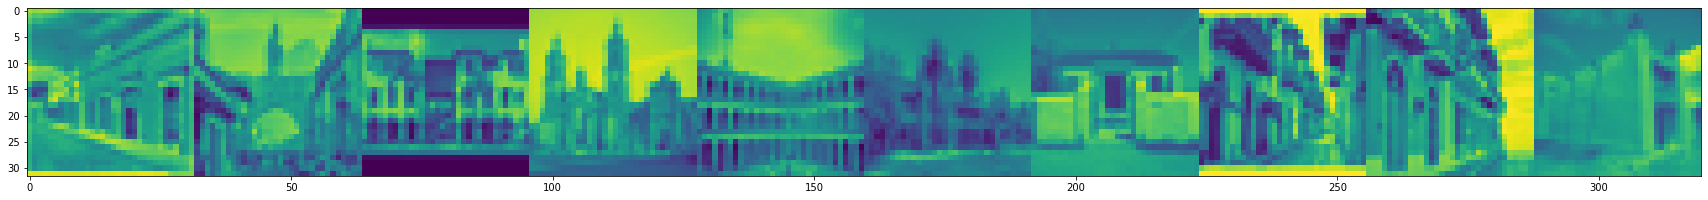

In [ ]:
conc = []
for i in data[100:110]:
  conc.append(i.T)
plt.figure(figsize=(30,30))
plt.imshow(np.concatenate(conc, axis=1))
plt.show()


### Baselines

In [ ]:
new_data = data.reshape((data.shape[0], -1))
X_train, x_test, Y_train, y_test = train_test_split(new_data, target, test_size=0.3)
for i in [X_train, x_test, Y_train, y_test]:
  print(i.shape)

(8603, 16384)
(3688, 16384)
(8603,)
(3688,)


In [ ]:
pipe = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_jobs=-1))
pipe.fit(X_train, Y_train)
print('KNN', pipe.score(x_test, y_test))
clf = RandomForestClassifier(n_jobs=-1).fit(X_train, Y_train)
print('Foest', clf.score(x_test, y_test))
clf = LogisticRegression(n_jobs=-1).fit(X_train, Y_train)
print('LogisticRegression', clf.score(x_test, y_test))
# clf = SVC()
# clf.fit(X_train, Y_train)
# print('SVC', clf.score(x_test, y_test))

KNN 0.15699566160520606
Foest 0.2651843817787419
Foest 0.19143167028199568


In [ ]:
clf = BaggingClassifier(base_estimator=RandomForestClassifier(n_jobs=-1), 
                        n_estimators=10)
clf.fit(X_train, Y_train)
clf.score(x_test, y_test)

0.2890455531453362

In [ ]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1)
clf.fit(X_train, Y_train)
clf.score(x_test, y_test)

Исходя из первичных результатов работы простых ML моделей, можно сделать вывод, что они не очень эффективны для решения данной задачи классификации. При увеличении качества изображений, есть небольой прирост в точности, однако скорость обучения сильно падает. 

## Neural networks 

### Подготовка данных

In [ ]:
# переносим все изображения одного стиля в одну папку
rootpath = '/content/Capstone_Architectural_Styles_dataset/'
list_style = os.listdir(rootpath)

for i in tqdm(range(len(list_style))):
  list_i = os.listdir(rootpath + list_style[i] + '/')
  target_dir = rootpath + list_style[i]
  for j in list_i:
    source_dir = rootpath + list_style[i] + '/' + j
    file_names = os.listdir(source_dir)
    for file_name in file_names:
      shutil.move(os.path.join(source_dir, file_name), target_dir)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
# Сделаем класс для загрузки данных
# если использовать предыдущий класс
# то оперативная память будет быстро переполняться

class ArchDataset(Dataset):
    def __init__(self, image_size, transforms, samples_in_class=None):
      self.image_size = image_size
      self.tfs = transforms
      self.path = '/content/Capstone_Architectural_Styles_dataset/'
      self.sourse_data = []
      self.code_style = {}
      classes = os.listdir(self.path)
      classes = sorted(classes)
      for i_class in range(len(classes)):
        self.code_style[i_class] = classes[i_class]
        samples = self.path + classes[i_class] + '/'
        data_class = [el for el in os.listdir(samples) if el.endswith('.jpg')]
        if samples_in_class:
          data_class = data_class[:samples_in_class]
        print(i_class, '-', classes[i_class], len(data_class))
        for i in data_class:
          self.sourse_data.append((i, i_class))

    def __len__(self):
      return len(self.sourse_data)
    
    def __getitem__(self, index):
      if type(index) == int:
        lable = self.sourse_data[index][1]
        img_path = os.path.join(self.path, 
                                self.code_style[lable],
                                self.sourse_data[index][0])
        im = Image.open(img_path).resize((self.image_size, self.image_size))
        im = np.array(im.convert('RGB'))
        result = (self.tfs(im), lable)

      elif type(index) == slice:
        n = slice(1,10)
        index = index.indices(len(self.sourse_data))
        result = []
        for i in range(*index):
          lable = self.sourse_data[i][1]
          img_path = os.path.join(self.path, 
                                  self.code_style[lable],
                                  self.sourse_data[i][0])
          im = Image.open(img_path).resize((self.image_size, self.image_size))
          im = np.array(im.convert('RGB'))
          result.append((self.tfs(im), lable))
      return result

    def show(self, ind1, ind2):
      conc = []
      for i in self.__getitem__(slice(ind1, ind2)):
        conc.append(i[0].T)
      plt.figure(figsize=(30,30))
      plt.imshow(np.concatenate(conc, axis =1))
      plt.show()

In [ ]:
# Аугментация данных
# https://pytorch.org/vision/master/transforms.html

tfs = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.CenterCrop(300),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = ArchDataset(370, tfs, 1200)
print(len(dataset))

0 - 21st_Century 1200
1 - Baroque 1089
2 - Classical 1022
3 - Early_Christian_Medieval 1200
4 - Eclecticism 1200
5 - Modernism 1200
6 - Neoclassicism 1200
7 - Renaissance_and_Colonialism 1200
8 - Revivalism 1200
10511


In [ ]:
print(dataset[0][0].shape)
print(dataset[0][0].dtype)

torch.Size([3, 300, 300])
torch.float32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2981.)


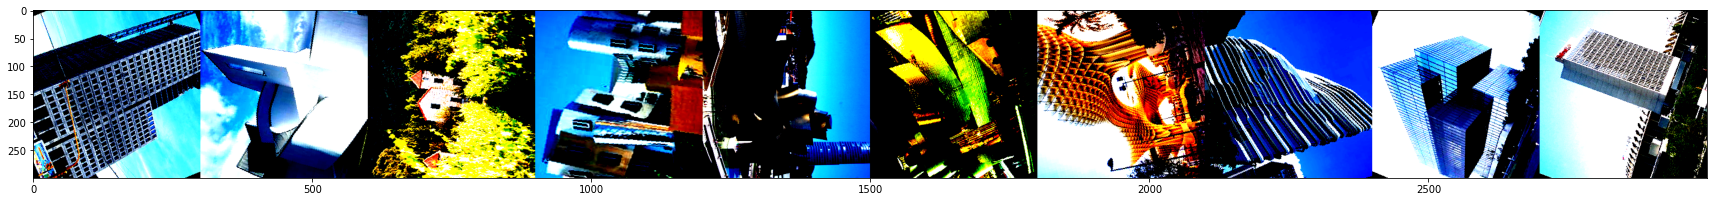

In [ ]:
dataset.show(100,110)

### Создание загрузчиков

In [ ]:
batch_size = 20
validation_split = .1
shuffle_dataset = True
random_seed= 50

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [ ]:
# устройство для вычисления (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Функция тренировки

In [ ]:
# функция тренировки
def train_model(model, train_loader, val_loader, 
                loss, optimizer, num_epochs, 
                see=True, graph=True, delta=0.001):  
    loss_history, train_history, val_history = [], [], []

    for epoch in range(num_epochs):
        model.train() # enter train mode
        loss_accum, correct_samples, total_samples = 0, 0, 0

        print(f'Epoch -- {epoch} --')
        for i_step, (x, y) in enumerate(tqdm(train_loader)):
            x_gpu, y_gpu = x.to(device), y.to(device)
            predict = model(x_gpu)    
            loss_value = loss(predict, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(predict, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
        
        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        if see: 
          print(f"Average loss: {ave_loss:.5f}")
          print(f"Train accuracy: {train_accuracy:.3f}")
          print(f"Val accuracy: {val_accuracy:.3f}")

        if delta and len(train_history) > 2:
          d = train_accuracy - train_history[-2]
          if d < delta:
            print(f'The delta is too small {d:.5f}')

    if graph:
      fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5), dpi = 300)
      ax1, ax2 = axes
      ax1.plot(list(range(1, num_epochs+1)), loss_history, label = 'loss_history')
      ax2.plot( list(range(1, num_epochs+1)),val_history, label = 'val')
      ax2.plot( list(range(1, num_epochs+1)),train_history, label = 'train')
      ax1.legend()
      ax2.legend()
      ax1.set_xlabel('epoch')
      ax1.set_ylabel('loss')
      ax1.set_title('Tensor board epoch')
      ax2.set_xlabel('epoch')
      ax2.set_ylabel('accuracy')
        
      print(f'min loss = {round(min(loss_history), 2)}')
      print(f'max val = {round(max(val_history), 2)}')
      print(f'max train = {round(max(train_history), 2)}')
      

    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    model.eval() # enter valuation mode
    correct_samples = 0
    total_samples = 0
    
    for i_step, (x, y) in enumerate(loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)              
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y_gpu.shape[0]  
    val_accuracy = float(correct_samples) / total_samples
    return val_accuracy

### FNN

In [ ]:
torch.cuda.empty_cache()
FNN_model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*64*64, 3*64*64+1000),
            nn.ReLU(inplace=True),
            nn.Linear(3*64*64+1000, 3*64*32),
            nn.ReLU(inplace=True),
            nn.Linear(3*64*32, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, 9),
            )

FNN_model.type(torch.cuda.FloatTensor)
loss_function = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)

# optimizer = optim.SGD(FCNN_model.parameters(), lr=1e-5, weight_decay=1e-1)
optimizer = optim.Adam(FNN_model.parameters(), lr=1e-5, weight_decay=1e-1)

loss_history, train_history, val_history = train_model(FNN_model, 
                                                       train_loader, 
                                                       validation_loader, 
                                                       loss_function, 
                                                       optimizer, 10)

  0%|          | 0/154 [00:00<?, ?it/s]

Average loss: 4.383541584014893
Train accuracy: 0.18509102003457745
Val accuracy: 0.19772172497965826


  0%|          | 0/154 [00:00<?, ?it/s]

Average loss: 2.1525967121124268
Train accuracy: 0.2535340181023086
Val accuracy: 0.23189585028478438


  0%|          | 0/154 [00:00<?, ?it/s]

Average loss: 2.0656955242156982
Train accuracy: 0.27733143496389706
Val accuracy: 0.18144833197721724


  0%|          | 0/154 [00:00<?, ?it/s]

Average loss: 1.9403132200241089
Train accuracy: 0.30702735685955457
Val accuracy: 0.2530512611879577


  0%|          | 0/154 [00:00<?, ?it/s]

Average loss: 1.8878884315490723
Train accuracy: 0.33916403945896473
Val accuracy: 0.2811228641171684


  0%|          | 0/154 [00:00<?, ?it/s]

Average loss: 1.8177109956741333
Train accuracy: 0.3612325841553951
Val accuracy: 0.2681041497152156


  0%|          | 0/154 [00:00<?, ?it/s]

Average loss: 1.7504953145980835
Train accuracy: 0.38401301739042004
Val accuracy: 0.2839707078925956


  0%|          | 0/154 [00:00<?, ?it/s]

Average loss: 1.7627506256103516
Train accuracy: 0.37963998779619645
Val accuracy: 0.2660699755899105


  0%|          | 0/154 [00:00<?, ?it/s]

Average loss: 1.6785186529159546
Train accuracy: 0.42062442794671007
Val accuracy: 0.2839707078925956


  0%|          | 0/154 [00:00<?, ?it/s]

Average loss: 1.6522616147994995
Train accuracy: 0.427641614969999
Val accuracy: 0.2933279088689992


### CNN

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# https://habr.com/ru/company/wunderfund/blog/315476/
CNN_model = nn.Sequential(
            nn.Conv2d(3, 200, 3, stride=1, padding=1),
            nn.BatchNorm2d(200),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(200, 250, 3, padding=1),
            nn.BatchNorm2d(250),
            nn.ReLU(inplace=True),
            nn.Conv2d(250, 150, 3, padding=1),
            nn.Dropout(p=0.3),
            nn.BatchNorm2d(150),
            nn.ReLU(inplace=True),
            nn.Conv2d(150, 100, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.BatchNorm2d(100),
            nn.Conv2d(100, 50, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(3200, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, 9),

          )

CNN_model.type(torch.cuda.FloatTensor)
CNN_model.to(device)

loss_function = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(CNN_model.parameters(), lr=8e-3, weight_decay=1e-4)

loss_history, train_history, val_history = train_model(CNN_model, 
                                                       train_loader, 
                                                       validation_loader, 
                                                       loss_function, 
                                                       optimizer, 100)

### Стандартные архитектуры сетей

In [ ]:
torch.cuda.empty_cache()

#### AlexNet

In [ ]:
# https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html
torch.cuda.empty_cache()

ANet = torchvision.models.AlexNet(9, 0.5)
ANet.type(torch.cuda.FloatTensor)
ANet.to(device)
loss_f = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(ANet.parameters(), lr=1e-1, weight_decay=1e-4, momentum=0.9)
train_model(ANet, 
            train_loader, 
            validation_loader, 
            loss_f, 
            optimizer, 100)

#### VGG

In [ ]:
# https://pytorch.org/vision/stable/_modules/torchvision/models/vgg.html
VGG16 = torchvision.models.vgg16(9)
VGG16.type(torch.cuda.FloatTensor)
VGG16.to(device)
loss_f = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
# optimizer = optim.SGD(VGG16.parameters(), lr=0.5, weight_decay=1e-4, momentum=0.9)
optimizer = optim.Adam(VGG16.parameters(), lr=0.005, weight_decay=1e-4)
train_model(VGG16, 
            train_loader, 
            validation_loader, 
            loss_f, 
            optimizer, 100)

In [ ]:
VGG19 = torchvision.models.vgg19(9)
VGG19.type(torch.cuda.FloatTensor)
VGG19.to(device)
loss_f = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(VGG19.parameters(), lr=0.005, weight_decay=1e-4, momentum=0.9)
train_model(VGG19, 
            train_loader, 
            validation_loader, 
            loss_f, 
            optimizer, 100)

#### ResNet

In [ ]:
# https://pytorch.org/vision/stable/_modules/torchvision/models/resnet.html
ResNet152 = torchvision.models.resnet152(9)
ResNet152.type(torch.cuda.FloatTensor)
ResNet152.to(device)
loss_f = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(ResNet152.parameters(), lr=0.0005, weight_decay=1e-3, momentum=0.9)
train_model(ResNet152, 
            train_loader, 
            validation_loader, 
            loss_f, 
            optimizer, 15)

#### Densenet 

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch -- 0 --


  0%|          | 0/473 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Average loss: 2.68716
Train accuracy: 0.407
Val accuracy: 0.583
Epoch -- 1 --


  0%|          | 0/473 [00:00<?, ?it/s]

Average loss: 1.13955
Train accuracy: 0.614
Val accuracy: 0.651
Epoch -- 2 --


  0%|          | 0/473 [00:00<?, ?it/s]

Average loss: 0.97345
Train accuracy: 0.670
Val accuracy: 0.667
Epoch -- 3 --


  0%|          | 0/473 [00:00<?, ?it/s]

Average loss: 0.88920
Train accuracy: 0.703
Val accuracy: 0.692
Epoch -- 4 --


  0%|          | 0/473 [00:00<?, ?it/s]

Average loss: 0.81296
Train accuracy: 0.723
Val accuracy: 0.701
Epoch -- 5 --


  0%|          | 0/473 [00:00<?, ?it/s]

Average loss: 0.76273
Train accuracy: 0.739
Val accuracy: 0.715
Epoch -- 6 --


  0%|          | 0/473 [00:00<?, ?it/s]

Average loss: 0.71360
Train accuracy: 0.759
Val accuracy: 0.709
Epoch -- 7 --


  0%|          | 0/473 [00:00<?, ?it/s]

Average loss: 0.66911
Train accuracy: 0.773
Val accuracy: 0.718
Epoch -- 8 --


  0%|          | 0/473 [00:00<?, ?it/s]

Average loss: 0.62647
Train accuracy: 0.791
Val accuracy: 0.748
Epoch -- 9 --


  0%|          | 0/473 [00:00<?, ?it/s]

Average loss: 0.59120
Train accuracy: 0.803
Val accuracy: 0.742
min loss = 0.59
max val = 0.75
max train = 0.8


([2.6871583461761475,
  1.1395543813705444,
  0.9734529256820679,
  0.889202892780304,
  0.8129587769508362,
  0.7627328038215637,
  0.713600218296051,
  0.6691054105758667,
  0.6264657974243164,
  0.5911996364593506],
 [0.406553911205074,
  0.6144820295983087,
  0.6697674418604651,
  0.703276955602537,
  0.7234672304439747,
  0.7387949260042284,
  0.7593023255813953,
  0.7733615221987316,
  0.7914376321353066,
  0.8027484143763214],
 [0.5832540437678402,
  0.6508087535680305,
  0.6669838249286394,
  0.6917221693625119,
  0.7012369172216937,
  0.7145575642245481,
  0.708848715509039,
  0.7183634633682208,
  0.7478591817316841,
  0.7421503330161751])

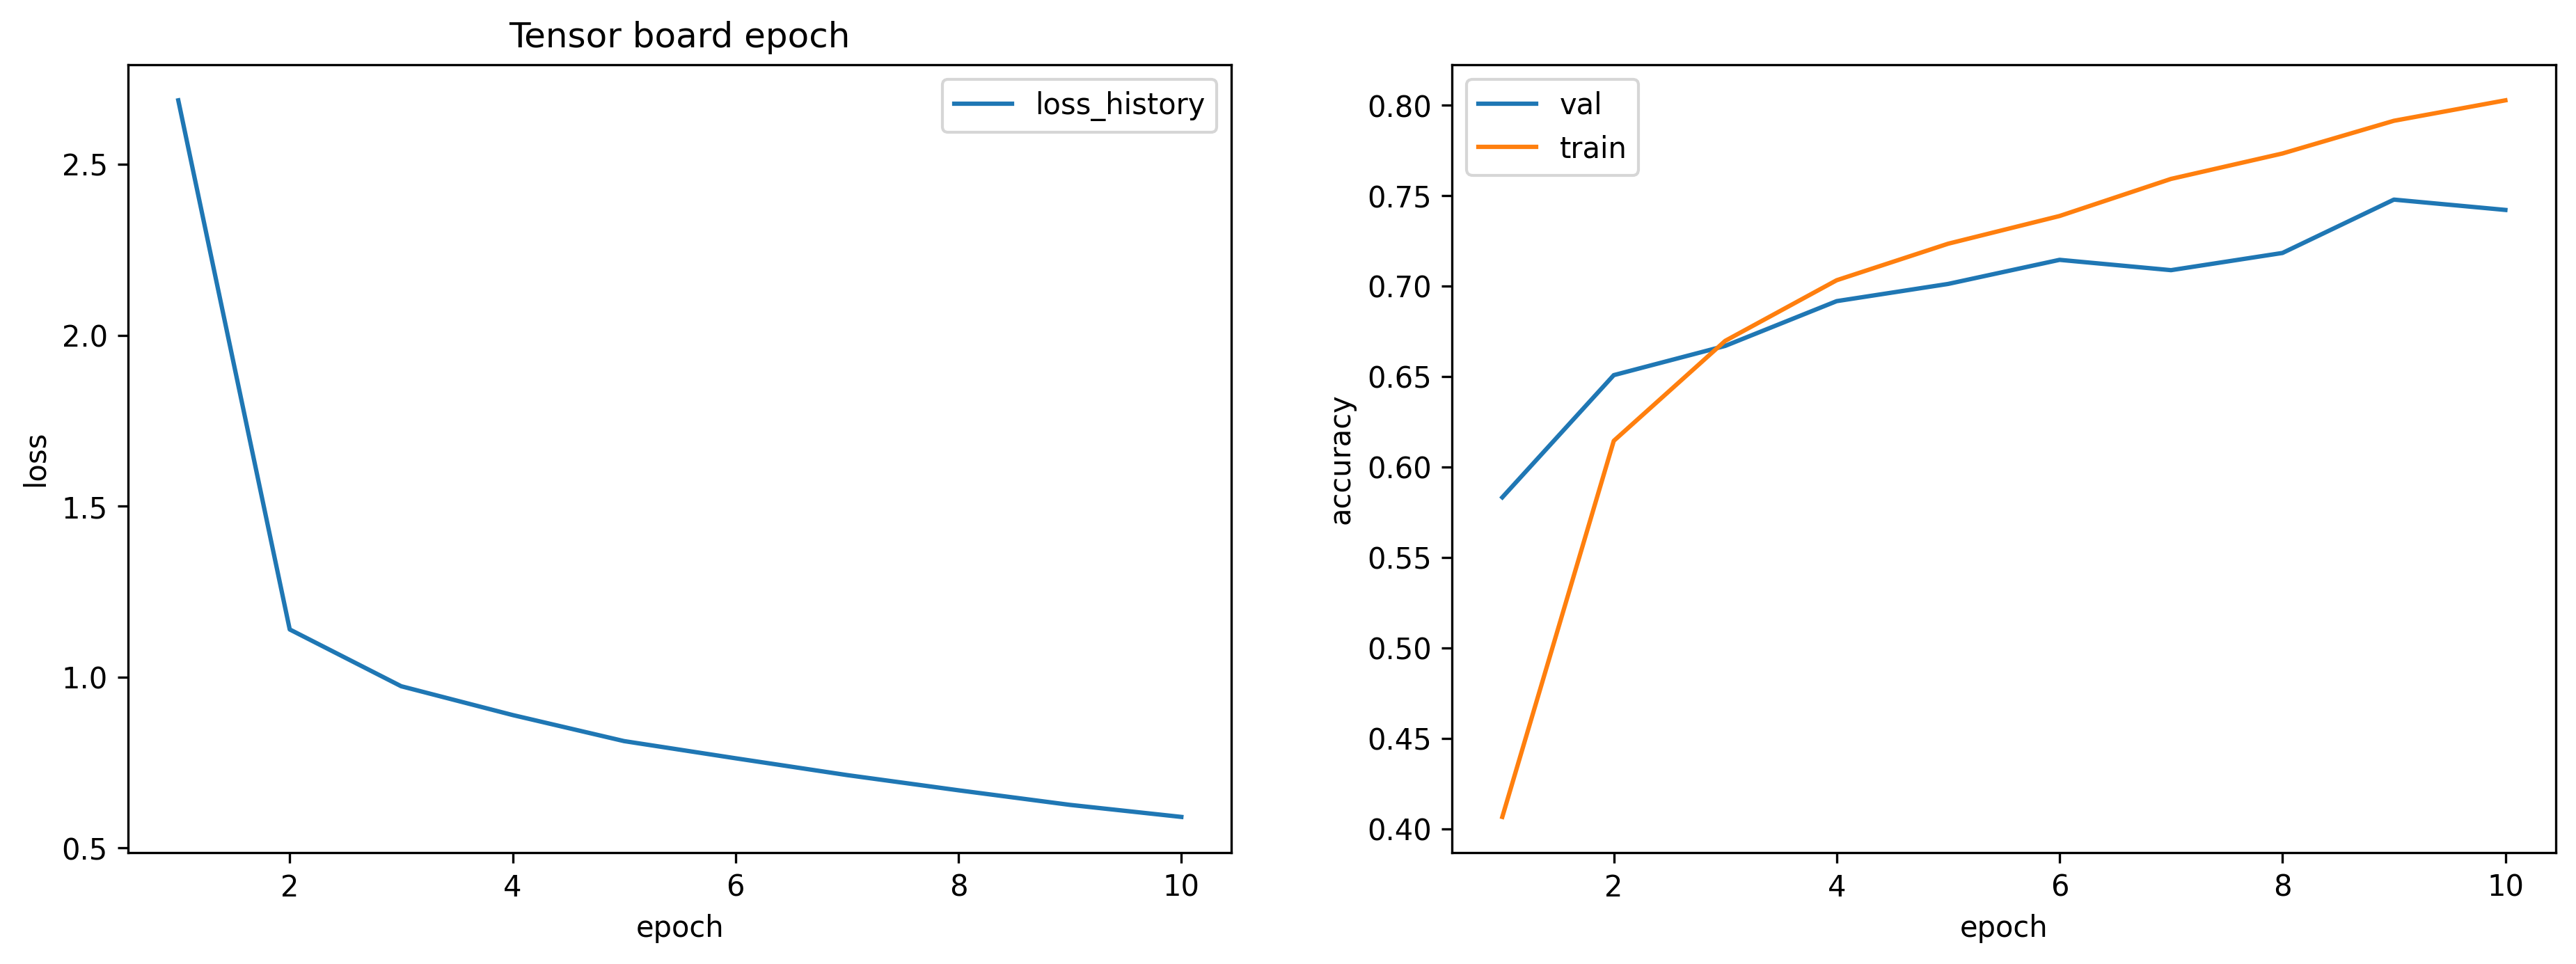

In [ ]:
# https://pytorch.org/vision/master/_modules/torchvision/models/densenet.html#DenseNet169
Densenet169 = torchvision.models.densenet169(9)
Densenet169.type(torch.cuda.FloatTensor)
Densenet169.to(device)
loss_f = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(Densenet169.parameters(), lr=0.0001, weight_decay=7e-3, momentum=0.9)
train_model(Densenet169, 
            train_loader, 
            validation_loader, 
            loss_f, 
            optimizer, 10)

#### Mobilenet

In [ ]:
mobilenet_v2 = torchvision.models.mobilenet_v2(9)
mobilenet_v2.type(torch.cuda.FloatTensor)
mobilenet_v2.to(device)
loss_f = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(mobilenet_v2.parameters(), lr=0.0007, weight_decay=7e-3, momentum=0.9)
train_model(mobilenet_v2, 
            train_loader, 
            validation_loader, 
            loss_f, 
            optimizer, 15)

#### Visual Transofrmer 
минимальный размер height=224, width=224

In [ ]:
torch.cuda.empty_cache()

vit_b_16 = torchvision.models.vit_b_16(9)
vit_b_16.type(torch.cuda.FloatTensor)
vit_b_16.to(device)
loss_f = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(vit_b_16.parameters(), lr=0.0005, weight_decay=1e-4, momentum=0.9)
train_model(vit_b_16, 
            train_loader, 
            validation_loader, 
            loss_f, 
            optimizer, 100)

#### ConvNeXt

In [ ]:
torch.cuda.empty_cache()

convnext_base = torchvision.models.convnext_base(9)
convnext_base.type(torch.cuda.FloatTensor)
convnext_base.to(device)
loss_f = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(convnext_base.parameters(), lr=0.005, weight_decay=1e-4, momentum=0.9)
train_model(convnext_base, 
            train_loader, 
            validation_loader, 
            loss_f, 
            optimizer, 100)

#### EfficientNet

In [ ]:
torch.cuda.empty_cache()

convnext_large = torchvision.models.efficientnet_v2_l(9)
convnext_large.type(torch.cuda.FloatTensor)
convnext_large.to(device)
loss_f = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(convnext_large.parameters(), lr=0.001, weight_decay=1e-2, momentum=0.9)
train_model(convnext_large, 
            train_loader, 
            validation_loader, 
            loss_f, 
            optimizer, 10)

#### Результаты обучения

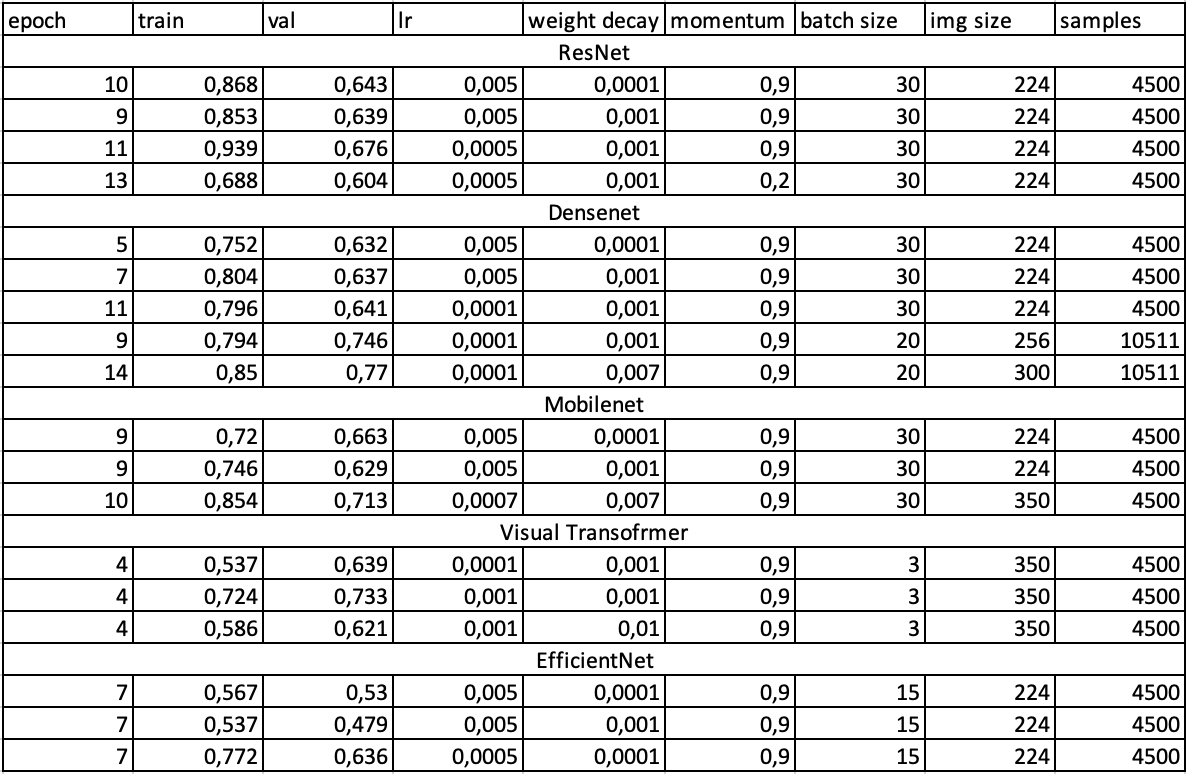

## Saving, loading and use model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(Densenet169.state_dict(), 'weight_Densenet169.pt') 

with open('code_style.txt', 'w') as f:
  f.write(str(dataset.code_style))

In [ ]:
f_model = torchvision.models.densenet169(9) # img size 300x300
f_model.load_state_dict(torch.load('weight_Densenet169.pt', map_location='cpu'))
f_model.eval()

In [ ]:
code_style = {0: '21st_Century', 
              1: 'Baroque', 
              2: 'Classical', 
              3: 'Early_Christian_Medieval', 
              4: 'Eclecticism', 
              5: 'Modernism', 
              6: 'Neoclassicism', 
              7: 'Renaissance_and_Colonialism', 
              8: 'Revivalism'}

In [ ]:
def pipe(img_path, model, code_style, image_size, crop, see=True):
  im = Image.open(img_path)
  if see:
    plt.axis('off')
    plt.imshow(im)
  im = im.resize((image_size,image_size))
  im = np.array(im.convert('RGB'))
  tfs = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop(crop),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])
  with torch.no_grad():
    pred = model(tfs(im)[None, :, :, :])
    return code_style[int(pred.max(1)[1])]

Neoclassicism


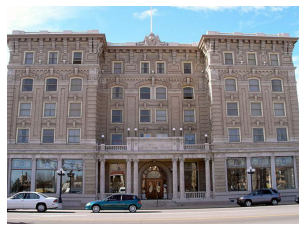

In [ ]:
path = '/content/Capstone_Architectural_Styles_dataset/Neoclassicism/60109.jpg'
result = pipe(path, f_model, code_style, 370, 300) 
print(result)

### Telegram bot test

In [ ]:
!pip install pyTelegramBotAPI
import telebot
from telebot import types

In [ ]:
bot = telebot.TeleBot(config.TOKEN)

bot.send_message(config.admin_id, 'Бот запущен')

@bot.message_handler(content_types=['document'])
def make_result(message):
  bot.send_message(message.chat.id, 'Фото в обработке')

  file_info = bot.get_file(message.document.file_id)
  downloaded_file = bot.download_file(file_info.file_path)
  src = '/content/' + message.document.file_name
  with open(src, 'wb') as f:
    f.write(downloaded_file)

  result = pipe(src, f_model, code_style, 370, 300, False) 
  bot.send_message(message.chat.id, f'Стиль {result}')

bot.polling(none_stop=True)

# Итоги
Главная задача не достигнута. Обучение моделей и перебор параметров является достаточно трудозатратным по времени процесс. Лучший accuracy, который получилось достигнуть на валидационных данных, 0.770. 

Задача требует доработки. Для улучщения результатов стоит попробовть изменить предобработку данных на входе модели и продолжить перебор гиперпараметров. Также можно найти другой набор данных, объединив с текущим. Можно попробовать обучить модель на большее количество классов, не объединяя их в общие

